In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data

In [9]:
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(months=36)]
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)
df = df[["Open"]].copy() 
print(df)

Adding Symbol: META
entry already exists or no title
       Open
0    207.68
1    209.87
2    204.78
3    209.02
4    202.37
..      ...
749  686.28
750  665.97
751  659.65
752  682.45
753  658.04

[754 rows x 1 columns]


In [10]:
df["lag_1"] = df["Open"].shift(1)
df["lag_2"] = df["Open"].shift(2)
df["lag_3"] = df["Open"].shift(3)

df.dropna(inplace=True)

Erreur quadratique moyenne (MSE) : 8906.2080


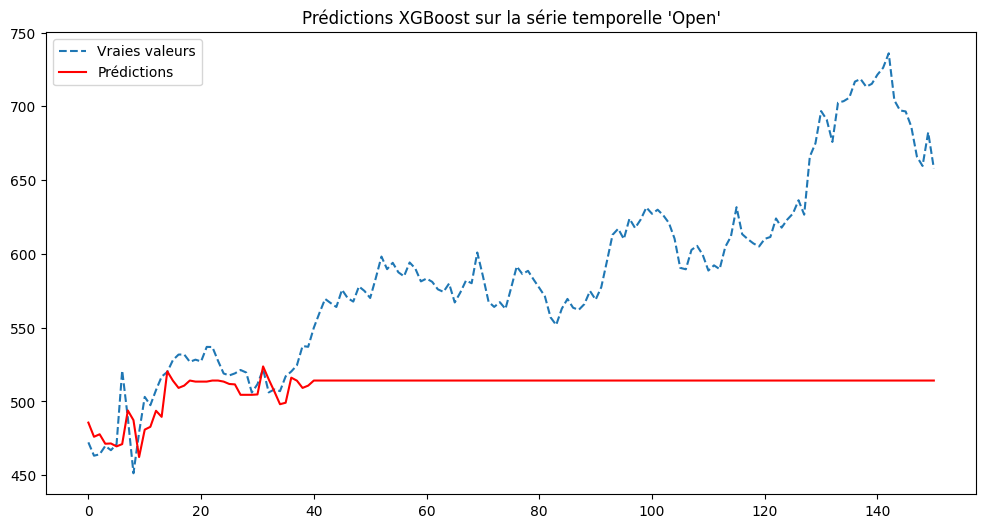

In [11]:
X = df.drop(columns=["Open"])
y = df["Open"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Vraies valeurs", linestyle='dashed')
plt.plot(y_pred, label="Prédictions", color='red')
plt.legend()
plt.title("Prédictions XGBoost sur la série temporelle 'Open'")
plt.show()